# Correlation matrix for TOC regressions

In [17]:
import altair as alt
import altair_saver
import intake
import os
import pandas as pd

import utils
import laplan

from IPython.display import display, SVG

alt.renderers.enable('altair_saver', fmts=['svg'])

RendererRegistry.enable('altair_saver')

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

bucket_name = 'city-planning-entitlements'

In [3]:
def prep_pcts():
    pcts = catalog.pcts.read()
    
    start = "10/1/2017"
    suffix = ["TOC"]

    pcts1 = laplan.pcts.subset_pcts(pcts, 
                                 start_date = start, 
                                 suffix_list = suffix, 
                                 get_dummies = True,
                                 verbose = True,
                                )

    cols = ["CASE_ID", "CASE_NUMBER", "AIN", "TOC"]
    pcts1 = pcts1[cols]
    
    return pcts1

In [4]:
pcts = prep_pcts()

Parsing PCTS case numbers
0 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'APCNV', 'HPO', 'PS', 'APCSV', 'APCH', 'TT', 'APCW', 'AA', 'ENV', 'CPC', 'VTT', 'APCS', 'CHC', 'APCE'}


In [5]:
# Import data
crosswalk_parcels_tracts = pd.read_parquet(f"s3://{bucket_name}/data/crosswalk_parcels_tracts_lacity.parquet")
census = catalog.census_analysis_table.read()

zoning = catalog.crosswalk_tracts_zone_class.read()

favorable_toc_zones = ["R2", "R3", "C2"]
zoning = zoning[["GEOID"] + favorable_toc_zones]

toc_eligible_tracts = (crosswalk_parcels_tracts[["GEOID", "total_AIN", "pct_toc_AIN", "toc_AIN"]]
                   .drop_duplicates()
                    .assign(
                       toc_AIN = crosswalk_parcels_tracts.toc_AIN.astype(bool)
                   )
                  )

tier_parcels = (
    crosswalk_parcels_tracts
    [crosswalk_parcels_tracts.TOC_Tier > 0]
    .groupby(["GEOID", "TOC_Tier"])
    .size()
    .to_frame("n")
    .reset_index(level=1)
    .pivot(columns="TOC_Tier", values="n")
    .rename(columns=lambda x: f"Tier_{x}")
    .fillna(0.0)
    .astype(int)
)

In [6]:
def assemble_data(pcts, crosswalk_parcels_tracts, tier_parcels, zoning, census):
    df = (pd.merge(
        pcts, 
        crosswalk_parcels_tracts[["uuid", "AIN", "GEOID", "total_AIN", "pct_toc_AIN", "toc_AIN"]], 
        how="inner", 
        on="AIN", 
        validate="m:1"
    ).merge(
        tier_parcels,
        how="left",
        on="GEOID",
        validate="m:1"
    ).merge(
        zoning, 
        how="left",
        on="GEOID",
        validate="m:1"
    ).merge(
        census, 
        how="left",
        on="GEOID",
        validate="m:1"
    ).fillna(0)
          .dropna()
          .rename(columns = {"toc_AIN": "TOC_eligible"})
          .drop_duplicates()
          .reset_index(drop=True)
    )
        
    # Get rid of duplicates 
    df = (df.sort_values(["CASE_ID", "uuid"])
          .drop_duplicates(subset = ["CASE_ID", "uuid"], keep="first")
          .reset_index(drop=True)
          .assign(
              TOC_eligible = df.TOC_eligible.astype(bool), 
              favorable_toc_zoning = df[favorable_toc_zones].sum(axis=1)
          )
         )
    
    return df

In [7]:
df = assemble_data(pcts, crosswalk_parcels_tracts, tier_parcels, zoning, census)

In [8]:
# These are tract-level columns to keep constant
group_cols = [
    "GEOID", 
    "pct_toc_AIN", "TOC_eligible", 
    "Tier_1", "Tier_2", "Tier_3", "Tier_4",
    "pct_pop_renter", "pct_whitenonhisp", "medhhincome", 
    "density", "favorable_toc_zoning"
]

# May have to tweak this and use the entitlements per tract function.
# For now, use this to test corr matrix.
summary = (df.groupby(group_cols)
           .agg({"TOC": "sum", "CASE_ID": "nunique"})
           .rename(columns = {"CASE_ID": "TOC_cases", 
                             "TOC": "TOC_entitlements"})
           .reset_index()
          )

In [9]:
correlation_long = summary.corr().reset_index().melt('index')
correlation_long.columns = ['var1', 'var2', 'correlation']

### Correlation matrix for all TOC variables

In [15]:
# Chart parameters
corr_step_size = 40
font_size = 10
chart_title_size = 14
font_name = "Roboto"

gold = "#FDBF11"
gray = "#EEEEEE"
navy = "#0A4C6A"

corr_domain = [-1.0, 1.0]
r_value_format = ".2f"
legend_value_format = ".1f"

grid_opacity = 0
stroke_opacity = 0
domain_opacity = 0.5

def show_svg(image_name):
    image_path = f"../notebooks/{image_name}.svg"
    altair_saver.save(image_name, image_path)
    display(SVG(filename = image_path))
    os.remove(image_path)

In [18]:
def correlation_matrix(df, chart_title):
    base = (alt.Chart(df)
        .transform_filter(
            alt.datum.var1 < alt.datum.var2
        ).encode(
            x=alt.X("var1", title="", axis=alt.Axis(ticks=False)),
            y=alt.Y("var2", title="", axis=alt.Axis(ticks=False))
        ).properties(
            width=alt.Step(corr_step_size),
            height=alt.Step(corr_step_size),
            title= chart_title,      
        )
    )

    rects = (base.mark_rect()
             .encode(
                 color = alt.Color(
                     'correlation', 
                     scale = alt.Scale(
                         domain = corr_domain,
                         range=[gold, gray, navy]),
                     legend = alt.Legend(
                         title="correlation",
                         format=legend_value_format
                     )
                ),
             )
    )

    text = (base.mark_text(
            size=font_size
        ).encode(
            text=alt.Text('correlation', format=r_value_format),
            color=alt.condition(
                "datum.correlation > 0.5",
                alt.value('white'),
                alt.value('black')
            )
        )
    )

    corr_matrix = (
        (rects + text)
             .configure_title(
                 fontSize = chart_title_size, font = font_name, anchor = "middle", color = "black"
             ).configure_axis(
                 domainOpacity = 0
             ).configure_view(
                 strokeOpacity = stroke_opacity
             )
        )

    show_svg(corr_matrix)

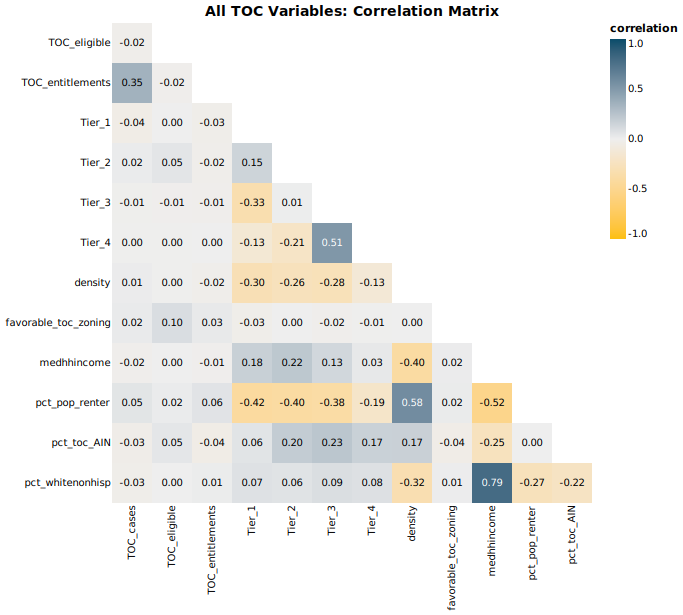

In [19]:
correlation_matrix(correlation_long, "All TOC Variables: Correlation Matrix")

### Correlation matrix for fewer variables

In [20]:
fewer_vars = ["TOC", "pct_toc_AIN", "TOC_eligible",
    "pct_pop_renter", "Tier_2", "Tier_3", "favorable_toc_zoning",
]
                
correlation_subset = correlation_long[
    (correlation_long.var1.isin(fewer_vars)) & 
    (correlation_long.var2.isin(fewer_vars))
]

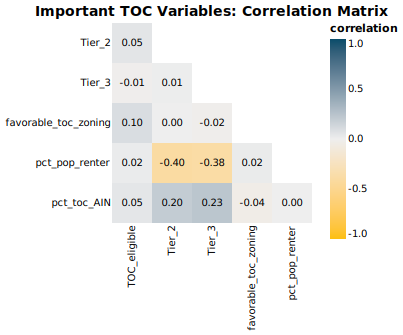

In [21]:
correlation_matrix(correlation_subset, "Important TOC Variables: Correlation Matrix")

### Scatter matrix for fewer variables

In [ ]:
scatter = (
    alt.Chart(summary).mark_circle()
    .encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color='TOC_eligible:O'
    ).properties(
        width=100,
        height=100
    ).repeat(
        row=regress_cols,
        column=regress_cols,
    )
)

scatter

In [12]:
base = alt.Chart(summary).transform_fold(
    ["pct_pop_renter", "favorable_toc_zoning", "Tier_2", "Tier_3"],
    as_=['key_x', 'value_x']
).transform_fold(
    ["pct_pop_renter", "favorable_toc_zoning", "Tier_2", "Tier_3"],
    as_=['key_y', 'value_y']
).encode(
    x=alt.X('value_x:Q', title=None),
    y=alt.Y('value_y:Q', title=None),
).properties(
    width=100,
    height=100,
)


scatter = (
    alt.layer(
        base.mark_circle(
            fillOpacity=0.2, size=8
        ).encode(
            color=alt.value(navy)
            # color really depends on which one is plotted first...whichever one is second gets masked
            #color=alt.Color('TOC_eligible:O',
                        #scale=alt.Scale(
                            #domain=["true", "false"], 
                            #range=[gold, navy])
                           #)
        ),
        base.transform_regression(
            'value_x', 'value_y',
            groupby=['key_x', 'key_y']
        ).mark_line(
            color='black', opacity=0.7
        ).encode(
            #detail='TOC_eligible:O',
        )
    ).facet(
        column=alt.Column('key_x:N', title=None),
        row=alt.Row('key_y:N', sort='descending')
    ).resolve_scale(
        x='independent',
        y='independent'
    ).properties(
        title="TOC Variables: Scatterplot Matrix"
    ).configure_title(
        fontSize = chart_title_size, font = font_name, anchor = "middle", color = "black"
    ).configure_axis(
        domainOpacity = domain_opacity,
        gridOpacity = grid_opacity,
    ).configure_view(
        strokeOpacity = stroke_opacity
    )
)


scatter

alt.FacetChart(...)

In [ ]:
# https://stackoverflow.com/questions/61277181/adding-r-value-correlation-to-scatter-chart-in-altair
chart = alt.Chart(summary[["Tier_3", "pct_pop_renter"]]).mark_circle().encode(
        alt.X('Tier_3',), #scale=alt.Scale(domain=(5,10))),
        y='pct_pop_renter'
)

correlation = summary[['Tier_3','pct_pop_renter']].corr().iloc[0,1]
correlation

text = alt.Chart({'values':[{}]}).mark_text(
    align="left", baseline="top"
).encode(
    x=alt.value(5),  # pixels from left
    y=alt.value(5),  # pixels from top
    text=alt.value(f"r: {correlation:.3f}"),
)

chart + text + chart.transform_regression('Tier_3','pct_pop_renter').mark_line()


In [ ]:
"""
# https://stackoverflow.com/questions/61447422/quick-way-to-visualise-multiple-columns-in-altair-with-regression-lines

import altair as alt
import pandas as pd

base = alt.Chart(iris).transform_fold(
    ['sepalLength', 'sepalWidth', 'petalLength','petalWidth'],
    as_=['key_x', 'value_x']
).transform_fold(
    ['sepalLength', 'sepalWidth', 'petalLength','petalWidth'],
    as_=['key_y', 'value_y']
).encode(
    x=alt.X('value_x:Q', title=None),
    y=alt.Y('value_y:Q', title=None),
).properties(
    width=100,
    height=100
)

alt.layer(
    base.mark_circle().encode(color='species:N'),
    base.transform_regression(
        'value_x', 'value_y',
        groupby=['key_x', 'key_y', 'species']
    ).mark_line(
        color='black'
    ).encode(
        detail='species:N'
    )
).facet(
    column=alt.Column('key_x:N', title=None),
    row=alt.Row('key_y:N', sort='descending')
).resolve_scale(
    x='independent',
    y='independent'
)
"""

In [ ]:
"""
https://github.com/altair-viz/altair/pull/1945

import altair as alt
from vega_datasets import data

df_iris = data.iris()
corrMatrix = df_iris.corr().reset_index().melt('index')
corrMatrix.columns = ['var1', 'var2', 'correlation']

base = alt.Chart(corrMatrix).transform_filter(
    alt.datum.var1 < alt.datum.var2
).encode(
    x='var1',
    y='var2',
).properties(
    width=alt.Step(100),
    height=alt.Step(100)
)

rects = base.mark_rect().encode(
    color='correlation'
)

text = base.mark_text(
    size=30
).encode(
    text=alt.Text('correlation', format=".2f"),
    color=alt.condition(
        "datum.correlation > 0.5",
        alt.value('white'),
        alt.value('black')
    )
)

rects + text
"""